In [68]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [69]:
df = pd.read_csv("./bse_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:30:00+05:30,101.89,103.22,101.79,103.00,330300
2018-01-01 09:45:00+05:30,103.00,103.78,102.67,103.06,306486
2018-01-01 10:00:00+05:30,103.06,103.33,102.79,103.11,182691
2018-01-01 10:15:00+05:30,103.11,103.66,102.95,103.42,125217
2018-01-01 10:30:00+05:30,103.42,103.56,103.28,103.44,58653


#### Creating Features

    Volume

In [70]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    RSI

In [71]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    49024.000000
mean        48.916402
std         17.922074
min          0.000000
25%         36.000000
50%         48.840841
75%         61.587403
max         99.194210
Name: rsi_14, dtype: float64

Overbought (>70): 6523 bars
Oversold (<30): 7823 bars


    MACD

In [72]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  49024.000000    49024.000000
mean       0.000360        0.000004
std        0.006217        0.001692
min       -0.038312       -0.021902
25%       -0.002589       -0.000732
50%       -0.000141       -0.000044
75%        0.002879        0.000658
max        0.043614        0.014145


    Moving Averages

In [73]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [74]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

    Candlestick/Microstructure Features

In [75]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (48785, 44)


#### Creating Target

In [76]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

    Shift to avoid lookahead bias

In [77]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

In [78]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

    Creating Target and Deciding Features

In [79]:
X = df[[
    "buying_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "body_size", 
]]


y = (df["shifted_log_return"] > 0).astype(int)


#### Model

datetime
2022-10-14 13:45:00+05:30    0
2022-10-14 14:00:00+05:30    1
2022-10-14 14:15:00+05:30    0
2022-10-14 14:30:00+05:30    0
2022-10-14 14:45:00+05:30    0
                            ..
2024-05-17 10:15:00+05:30    0
2024-05-17 10:30:00+05:30    0
2024-05-17 10:45:00+05:30    1
2024-05-17 11:00:00+05:30    1
2024-05-17 11:15:00+05:30    0
Name: shifted_log_return, Length: 9756, dtype: int64
Test score - 0.5133251332513326
Validation score - 0.502460024600246
Train score - 0.9998291649583162
Train confusion matrix - [[2814 2236]
 [2512 2194]]
              precision    recall  f1-score   support

           0       0.53      0.56      0.54      5050
           1       0.50      0.47      0.48      4706

    accuracy                           0.51      9756
   macro avg       0.51      0.51      0.51      9756
weighted avg       0.51      0.51      0.51      9756

Training Accuracy Scores: [0.5622864561978953, 0.5712040453737871, 0.5784132841328413]
Validation Accuracy Scores: [

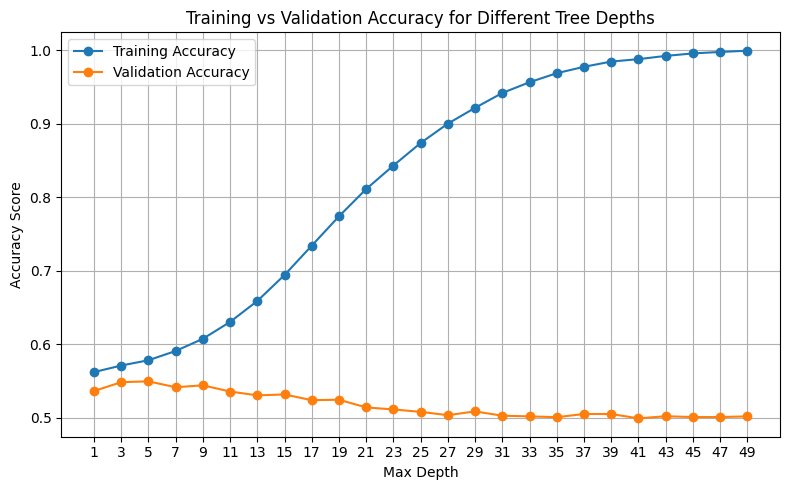

In [80]:
model_preparation(X, y)

In [81]:
model = best_model(X, y, max_depth=5)

Test score - 0.5235752357523575
Validation score - 0.5497129971299713
Train score - 0.5784132841328413
Train confusion matrix - [[3581 1469]
 [3179 1527]]
              precision    recall  f1-score   support

           0       0.53      0.71      0.61      5050
           1       0.51      0.32      0.40      4706

    accuracy                           0.52      9756
   macro avg       0.52      0.52      0.50      9756
weighted avg       0.52      0.52      0.51      9756



#### Feature Importance

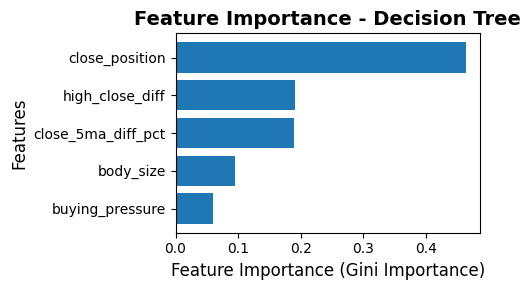


Top 10 Most Important Features:
           feature  importance
    close_position    0.463368
   high_close_diff    0.191085
close_5ma_diff_pct    0.189916
         body_size    0.095528
   buying_pressure    0.060103

Bottom 10 Least Important Features:
           feature  importance
    close_position    0.463368
   high_close_diff    0.191085
close_5ma_diff_pct    0.189916
         body_size    0.095528
   buying_pressure    0.060103


In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the decision tree
feature_importance = pd.DataFrame({
    'feature': X.columns,  # Your feature names
    'importance': model.feature_importances_  # Feature importances for tree models
}).sort_values('importance', ascending=False)

# Create the chart
plt.figure(figsize=(5, 3))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Print bottom 10 features (least important)
print("\nBottom 10 Least Important Features:")
print(feature_importance.tail(10).to_string(index=False))

# Show features with zero importance (can be removed)
zero_importance = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance) > 0:
    print(f"\n{len(zero_importance)} features have ZERO importance (consider removing):")
    print(zero_importance['feature'].tolist())

#### Trade Results

#### Trade Results